In [2]:
import numpy as np
import matplotlib.pyplot as plt
from molecule import CaOH, CaH, mu_N, gI
from scipy.constants import h, k
%matplotlib inline

import qls
import utils as ut

In [3]:
def apply_noise(value, noise_type, noise_level, seed=None):
    """Applica il rumore a un dato valore con un controllo sul seed.
    
    Parameters:
        value (float): Valore originale.
        noise_type (str): Tipo di rumore ('uniform', 'gaussian', o 'normal').
        noise_level (float): Percentuale di errore.
        seed (int, optional): Seed per rendere il rumore riproducibile. Se None, il rumore sarà diverso ad ogni chiamata.
    
    Returns:
        float: Valore con rumore applicato.
    """
    if seed is not None:
        np.random.seed(seed)  # Imposta il seed per la riproducibilità

    if noise_type == "uniform":
        error = noise_level * value * np.random.uniform(-1, 1)
    elif noise_type == "gaussian" or noise_type == "normal":
        error = noise_level * value * np.random.normal(0, 1)
    else:
        error = 0

    return value + error

In [30]:
import numpy as np
from molecule import Molecule
from scipy.constants import h, k
from scipy.sparse import csr_array, sparray
from typing import Tuple, Optional, NamedTuple
from wigners import clebsch_gordan
import pandas as pd
from typing import List, Dict


class Polarization(NamedTuple):
    pi: float
    sp: float
    sm: float


def get_excitation_probabilities(
    molecule: Molecule,
    frequency: float,
    duration_us: float,
    rabi_rate_mhz: float,
    dephased: bool = False,
    coherence_time_us: float = 100.0,
    is_minus: bool = True,
    noise_params: Dict[str, Dict[str, float]] = None,
    seed: int = None
) -> np.ndarray:
    """Returns the excitation probabilities for given frequency and other parameters

    Args:
        molecule (Molecule): The molecule to calculate the excitation probabilities for
        frequency (float): The frequency of the excitation pulse in MHz
        duration_us (float): The duration of the excitation pulse in microseconds
        rabi_rate_mhz (float): The Rabi rate in MHz
        dephased (bool): If True, the excitation is dephased
        coherence_time_us (float): The coherence time in us for rabi flopping
        is_minus (bool): If True, the excitation is for dm = -1
    Returns:
        np.ndarray: The excitation probabilities for each state
    """


    if noise_params is None:
        noise_params = {}

    # Applicare rumore separato per ogni parametro se specificato
    if "frequency" in noise_params:
        frequency = apply_noise(frequency, noise_params["frequency"]["type"], noise_params["frequency"]["level"], seed)
    if "rabi_rate" in noise_params:
        rabi_rate_mhz = apply_noise(rabi_rate_mhz, noise_params["rabi_rate"]["type"], noise_params["rabi_rate"]["level"], seed)



    state_exc_probs = np.zeros(len(molecule.state_df))

    if is_minus:
        detunings = 2 * np.pi * (frequency - molecule.transition_df["energy_diff"].to_numpy(dtype=float) * 1e-3)
    else:
        detunings = 2 * np.pi * (frequency + molecule.transition_df["energy_diff"].to_numpy(dtype=float) * 1e-3)


    # detunings = 2 * np.pi * (frequency - molecule.transition_df["energy_diff"].to_numpy(dtype=float) * 1e-3)
    omegas = rabi_rate_mhz * molecule.transition_df["coupling"].to_numpy(dtype=float)

    if dephased:
        transition_exc_probs = omegas**2 / (omegas**2 + detunings**2) * ((1 - np.cos(np.sqrt(omegas**2.0 + detunings**2.0) * duration_us) * np.exp(-duration_us / coherence_time_us)) / 2)
    else:
        transition_exc_probs = omegas**2 / (omegas**2 + detunings**2) * np.sin(np.sqrt(omegas**2.0 + detunings**2.0) * duration_us / 2) ** 2

    if is_minus:
        # state1 --> state2
        states_index = molecule.transition_df["index1"].to_numpy(dtype=int)
    else:
        # state2 --> state1
        states_index = molecule.transition_df["index2"].to_numpy(dtype=int)

    for i in range(len(molecule.transition_df)):
        state_exc_probs[states_index[i]] += transition_exc_probs[i]

    return state_exc_probs, frequency, rabi_rate_mhz



def get_spectrum(
    molecule: Molecule,
    state_distribution: np.ndarray,
    duration_us: float,
    rabi_rate_mhz: float,
    max_frequency_mhz: float,
    scan_points: int,
    dephased: bool = True,
    coherence_time_us: float = 100.0,
    is_minus: bool = True,
    noise_params: Dict[str, Dict[str, float]] = None,
    seed: int = None
) -> Tuple[np.ndarray, np.ndarray]:
    """Returns the spectrum for given parameters

    Args:
        molecule (Molecule): The molecule to calculate the spectrum for
        duration_us (float): The duration of the excitation pulse in microseconds
        rabi_rate_mhz (float): The Rabi rate in MHz
        max_frequency_mhz (float): The maximum frequency in MHz
        scan_points (int): The number of scan points
        dephased (bool): If True, the excitation is dephased
        is_minus (bool): If True, the excitation is for dm = -1; otherwise, dm = +1
    Returns:
        np.ndarray: The excitation probabilities for each frequency
    """
    frequencies = np.linspace(-max_frequency_mhz, max_frequency_mhz, scan_points)
    exc_probs = [
        np.dot(
            get_excitation_probabilities(molecule, frequency, duration_us, rabi_rate_mhz, dephased, coherence_time_us, is_minus, noise_params, seed),
            state_distribution,
        )
        for frequency in frequencies
    ]
    return frequencies, exc_probs




def excitation_matrix(
    molecule: Molecule,
    frequency: float,
    duration_us: float,
    rabi_rate_mhz: float,
    dephased: bool = False,
    coherence_time_us: float = 1000.0,
    is_minus: bool = True,
    noise_params: Dict[str, Dict[str, float]] = None,
    seed: int = None
) -> sparray:
    """Returns the excitation probabilities for given frequency and other parameters

    Args:
        molecule (Molecule): The molecule to calculate the excitation probabilities for
        frequency (float): The frequency of the excitation pulse in MHz
        duration_us (float): The duration of the excitation pulse in microseconds
        rabi_rate_mhz (float): The Rabi rate in MHz
        dephased (bool): If True, the excitation is dephased
        coherence_time_us (float): The coherence time in us for rabi flopping
        is_minus (bool): If True, the excitation is for dm = -1
    Returns:
        np.ndarray: The excitation probabilities for each state
    """


    if noise_params is None:
        noise_params = {}

    # Applicare rumore separato per ogni parametro se specificato
    if "frequency" in noise_params:
        frequency = apply_noise(frequency, noise_params["frequency"]["type"], noise_params["frequency"]["level"], seed)
    if "rabi_rate" in noise_params:
        rabi_rate_mhz = apply_noise(rabi_rate_mhz, noise_params["rabi_rate"]["type"], noise_params["rabi_rate"]["level"], seed)


    num_states = len(molecule.state_df)


    if is_minus:
        detunings = 2 * np.pi * (frequency - molecule.transition_df["energy_diff"].to_numpy(dtype=float) * 1e-3)
    else:
        detunings = 2 * np.pi * (frequency + molecule.transition_df["energy_diff"].to_numpy(dtype=float) * 1e-3)

    # detunings = 2 * np.pi * (frequency - molecule.transition_df["energy_diff"].to_numpy(dtype=float) * 1e-3)
    omegas = rabi_rate_mhz * molecule.transition_df["coupling"].to_numpy(dtype=float)

    if dephased:
        transition_exc_probs = omegas**2 / (omegas**2 + detunings**2) * ((1 - np.cos(np.sqrt(omegas**2.0 + detunings**2.0) * duration_us) * np.exp(-duration_us / coherence_time_us)) / 2)
    else:
        transition_exc_probs = omegas**2 / (omegas**2 + detunings**2) * np.sin(np.sqrt(omegas**2.0 + detunings**2.0) * duration_us / 2) ** 2
        
    if is_minus:
        # state1 --> state2
        rows = molecule.transition_df["index2"].to_numpy(dtype=int)
        cols = molecule.transition_df["index1"].to_numpy(dtype=int)
        exc_matrix = csr_array((transition_exc_probs, (rows, cols)), shape=(num_states, num_states)) + csr_array((-transition_exc_probs, (cols, cols)), shape=(num_states, num_states))
    else:
        # state2 --> state1
        rows = molecule.transition_df["index1"].to_numpy(dtype=int)
        cols = molecule.transition_df["index2"].to_numpy(dtype=int)
        exc_matrix = csr_array((transition_exc_probs, (rows, cols)), shape=(num_states, num_states)) + csr_array((-transition_exc_probs, (cols, cols)), shape=(num_states, num_states))

    return exc_matrix


# def apply_pumping(mo1, pump_frequency_mhz, num_pumps, pump_duration_us, pump_rabi_rate_mhz, pump_dephased, coherence_time_us, is_minus, noise_params, seed):

def apply_pumping(
    mo1: Molecule,
    pump_frequency_mhz: float,
    num_pumps: int,
    pump_duration_us: float,
    pump_rabi_rate_mhz: float,
    pump_dephased: bool = False,
    coherence_time_us: float = 1000.0,
    is_minus: bool = True,
    noise_params: Dict[str, Dict[str, float]] = None,
    seed: int = None
) -> None:
    # print("freq = ", pump_frequency_mhz)
    # print("num_pumps = ", num_pumps)
    # print("pump_duration_us = ", pump_duration_us)
    # print("pump_rabi_rate_mhz = ", pump_rabi_rate_mhz)
    # print("pump_dephased = ", pump_dephased)
    # print("coherence_time_us = ", coherence_time_us)
    # print("is_minus = ", is_minus)
    # print("noise_params = ", noise_params)
    # print("seed = ", seed)

    for _ in range(num_pumps):


        exc_matrix = excitation_matrix(mo1, pump_frequency_mhz, pump_duration_us, pump_rabi_rate_mhz, pump_dephased, coherence_time_us, is_minus, noise_params, seed).dot(mo1.state_df["state_dist"])
        mo1.state_df["state_dist"] += exc_matrix


        mask = mo1.state_df["state_dist"] < 0
        if np.abs(sum(exc_matrix)) >= 1e-10:
            raise ValueError("Error: sum of exc_matrix is not 0")

        if (mo1.state_df["state_dist"].shape) != (exc_matrix.shape):
            raise ValueError(f"Error: Shape mismatch. state_dist has shape {mo1.state_df['state_dist'].shape}, but exc_matrix has shape {exc_matrix.shape}")

        if np.sum(mask) > 0 : 
            raise ValueError("Error: state_dist contains negative values")



def get_thermal_distribution(molecule: Molecule, temperature: float) -> np.ndarray:
    """Returns the thermal distribution for a given temperature

    Args:
        molecule (Molecule): The molecule to calculate the thermal distribution for
        temperature (float): The temperature in Kelvin
    Returns:
        np.ndarray: The thermal distribution for each state
    """
    rotational_energy_ghz = molecule.state_df["rotation_energy_ghz"].to_numpy()


    state_distribution = np.exp(-h * rotational_energy_ghz * 1e9 / (k * temperature))


    state_distribution /= np.sum(state_distribution)

    return state_distribution




class States:
    """Class to store the state distribution of the given molecule"""

    def __init__(self, molecule: Molecule, temperature: Optional[float] = None):
        """Initializes the States object

        Args:
            molecule (Molecule): The molecule to store the state distribution for
            temperature (float): The temperature in Kelvin, if None, the state distribution is uniform
        """
        self.molecule = molecule
        self.num_states = len(molecule.state_df)
        self.j = molecule.state_df["j"].to_numpy(dtype=int)

        if temperature is not None:
            self.dist = get_thermal_distribution(molecule, temperature)
        else:
            self.dist = np.ones(len(molecule.state_df)) / len(molecule.state_df)

        self.molecule.state_df["state_dist"] = self.dist

    def j_distribution(self) -> np.ndarray:
        """Returns the distribution of the rotational states"""
        return np.bincount(self.j, weights=self.dist)


In [35]:
b_field_gauss = 3.6
j_max = 10

mo1 = CaH.create_molecule_data(b_field_gauss=b_field_gauss, j_max=j_max)


noise_params = {
    "frequency": {"type": "gaussian", "level": 0.01},
    "rabi_rate": {"type": "uniform", "level": 0.02}
}

del_fr = []
del_rr = []
for i in range(1000):
    excitation_probs, ff, rr = get_excitation_probabilities(
        mo1, 
        frequency=100.0, 
        duration_us=5000.0, 
        rabi_rate_mhz=0.005, 
        noise_params=noise_params,
        seed=None  # Seed per la riproducibilità
    )

    del_fr.append(ff)
    del_rr.append(rr)



In [36]:
print(del_fr)

[98.88811988195307, 100.31890218468938, 100.27904129220013, 101.01051528480653, 99.41912186597648, 99.47483019282186, 97.3874509873064, 100.9503696823969, 99.57195393582377, 99.25759316288082, 99.37052503907574, 100.5977204669126, 100.12221916522267, 99.48456433790754, 99.39974614989409, 100.94743982104664, 98.97844780532441, 99.83824461360248, 99.77054954616804, 100.38934891325613, 102.77831304155244, 101.19363972428232, 100.21863831605386, 100.88176103894861, 98.9909146571349, 98.41670578646311, 98.65332190263865, 99.1194087339529, 100.58212279471304, 100.88774845959335, 99.79283410989542, 99.37652260501504, 98.49184671045252, 101.09964697578482, 101.1797163447007, 99.10179206054433, 98.96217012348451, 99.92419625497182, 101.49543425288347, 100.33818125199332, 99.60136160998479, 99.93913591252526, 98.5812495414086, 101.04249161733942, 99.4655835463265, 98.50494612918567, 99.78783857828837, 99.57313120596028, 100.5014483315248, 101.15818665293203, 101.37186213354978, 100.1755532939548

In [12]:
# Taken from Chou et al.

gj_list: list[float] = [-1.35, -1.35, -1.35, -1.34, -1.34, -1.34, -1.34, -1.34, -1.33, -1.33, -1.33, -1.32, -1.32, -1.31, -1.31]

cij_list: list[float] = [8.27, 8.26, 8.26, 8.26, 8.26, 8.25, 8.25, 8.24, 8.24, 8.23, 8.22, 8.21, 8.20, 8.19, 8.18]

b_field_gauss = 3.6
j_max = 14

# mo1 = CaH.create_molecule_data(b_field_gauss=b_field_gauss, j_max=j_max)
mo1 = CaH.create_molecule_data(b_field_gauss=b_field_gauss, j_max=j_max, gj_list = gj_list, cij_list = cij_list)

temperature = 300
states1 = qls.States(mo1, temperature)


[0.00721205 0.00721205 0.00721205 0.00721205 0.00721205 0.00721205
 0.00721205 0.00721205 0.00721205 0.00721205 0.00721205 0.00721205
 0.00721205 0.00721205 0.00721205 0.00721205 0.00721205 0.00721205]
[0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]


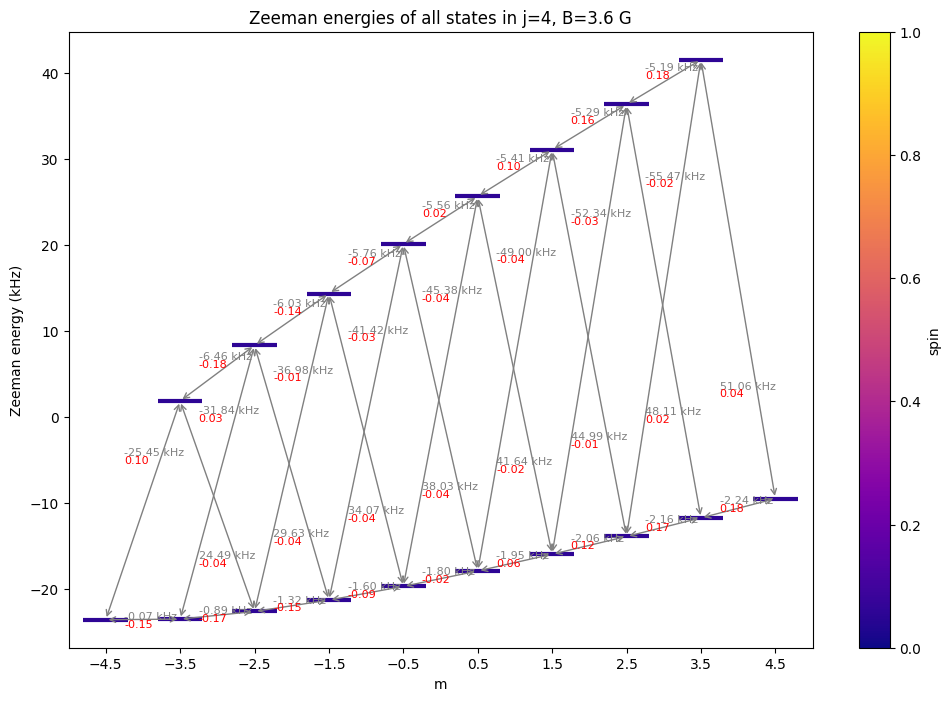

In [13]:
ut.plot_state_dist(mo1, 4)

[7.24967423e-02 1.89176736e-02 3.05507846e-03 2.30399022e-03
 4.77357988e-03 2.01401141e-02 7.39952843e-03 6.21359527e-04
 5.34498332e-05 5.08698166e-05 1.65847125e-06 9.88495951e-07
 8.16961660e-07 1.01655475e-06 4.46023677e-09 1.41607307e-10
 3.85641524e-53 2.28080378e-54]
[5.58453933e-01 1.45725847e-01 2.35337552e-02 1.77480030e-02
 3.67716448e-02 1.55142501e-01 5.69997440e-02 4.78643123e-03
 4.11732563e-04 3.91858285e-04 1.27754677e-05 7.61454148e-06
 6.29318556e-06 7.83068289e-06 3.43579130e-08 1.09082360e-09
 2.97065798e-52 1.75693942e-53]


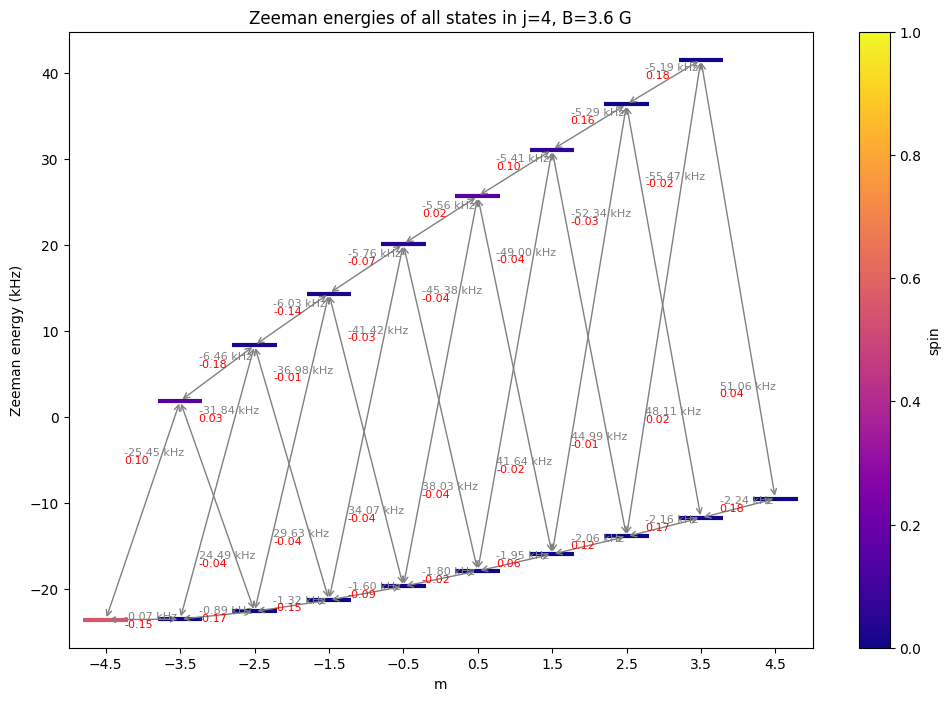

In [14]:
signature_transitions = np.array([mo1.transition_df.loc[mo1.transition_df["j"]==j].iloc[0]["energy_diff"] * 1e-3 for j in range(1, mo1.j_max+1)])


pump_list = {
    'pump_frequency_mhz': -0.002,
    'num_pumps': 200,
    'pump_duration_us': 1000.0,
    'pump_rabi_rate_mhz': 2*np.pi*0.004,
    'pump_dephased': True,
    'coherence_time_us': 100,
    'is_minus': True
}


apply_pumping(mo1 = mo1, **pump_list, noise_params = None, seed = None)


ut.plot_state_dist(mo1, 4)

[7.44573304e-02 5.33385622e-02 7.94491604e-05 5.32106818e-05
 9.28186991e-05 1.75961358e-03 8.07008418e-17 2.27845074e-25
 9.23811762e-27 2.03298141e-05 2.10786716e-06 3.28748746e-06
 8.87195675e-06 1.27764152e-06 1.17179404e-08 1.05553206e-10
 1.99432677e-54 7.12118526e-56]
[5.73556654e-01 4.10875425e-01 6.12009515e-04 4.09890342e-04
 7.14997197e-04 1.35545832e-02 6.21651416e-16 1.75512683e-24
 7.11626888e-26 1.56603791e-04 1.62372359e-05 2.53240386e-05
 6.83420934e-05 9.84187579e-06 9.02651582e-08 8.13093125e-10
 1.53626162e-53 5.48556223e-55]


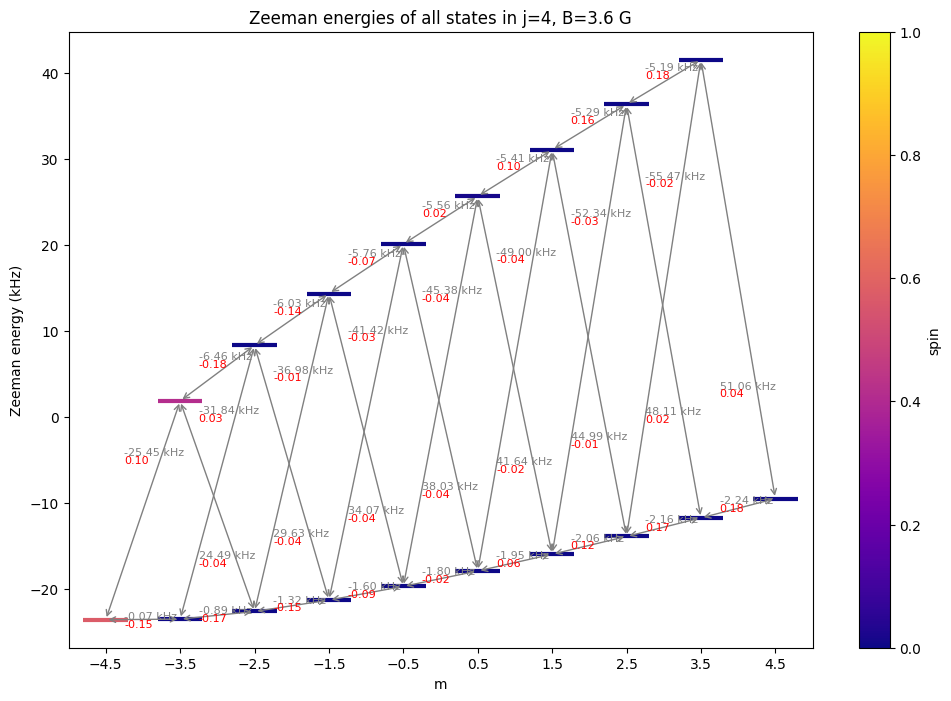

In [15]:
# pump_list = {
#     'pump_frequency_mhz': -0.006,
#     'num_pumps': 200,
#     'pump_duration_us': 1000.0,
#     'pump_rabi_rate_mhz': 2*np.pi*0.004,
#     'pump_dephased': True,
#     'coherence_time_us': 100,
#     'is_minus': True
# }

pump_list['pump_frequency_mhz'] = -0.006


apply_pumping(mo1 = mo1, **pump_list, noise_params = None, seed = None)



ut.plot_state_dist(mo1, 4)

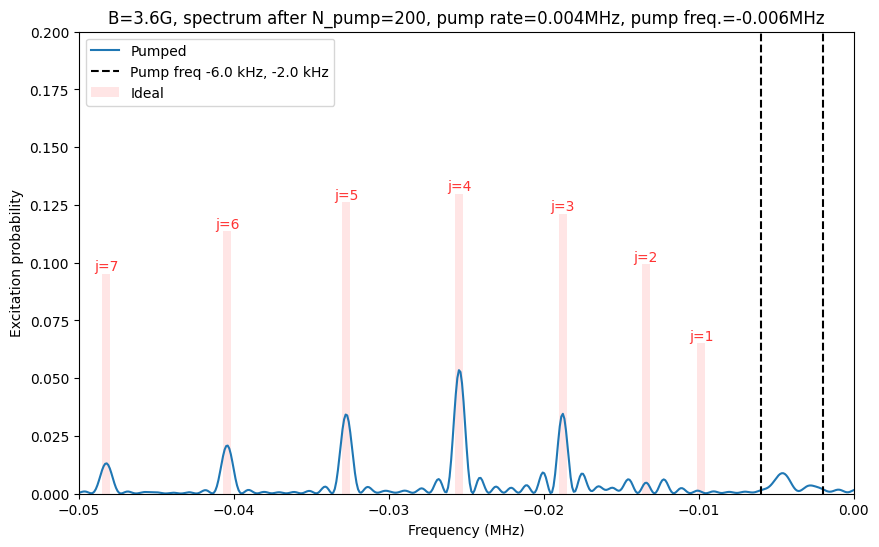

In [19]:
spectrum_list = {
    'duration_us': 1000,
    'rabi_rate_mhz': 2*np.pi*0.005,
    'max_frequency_mhz': 0.05,
    'scan_points': 1000,
    'dephased': False,
    'coherence_time_us': 100,
    'is_minus': True
}



fig, ax = plt.subplots(figsize=(10, 6))

frequencies, exc_probs1_after = get_spectrum(molecule=mo1,state_distribution=mo1.state_df["state_dist"], **spectrum_list, noise_params=None, seed=None)

ax.plot(frequencies, exc_probs1_after, label = f"Pumped")      # Plot after pumping



ax.bar(signature_transitions, states1.j_distribution()[1:], color="red", width=0.0005, alpha=0.1, label = "Ideal")
ax.axvline(x=-0.002, color='black', linestyle='--')
ax.axvline(x=-0.006, color='black', linestyle='--', label=f'Pump freq {-0.006*(1e3)} kHz, {-0.002*(1e3)} kHz')
ax.legend()
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Excitation probability")
ax.set_title(f"B={b_field_gauss}G, spectrum after N_pump={pump_list['num_pumps']}, pump rate={pump_list['pump_rabi_rate_mhz']/(2*np.pi):.3f}MHz, pump freq.={pump_list['pump_frequency_mhz']}MHz")

a_lim = -spectrum_list['max_frequency_mhz']
b_lim = 0
ax.set_xlim([a_lim, b_lim])
ax.set_ylim([0, 0.2])

for i in range(j_max):
    if signature_transitions[i] >= a_lim and signature_transitions[i] <= b_lim:
        ax.text(signature_transitions[i], states1.j_distribution()[i+1], f"j={i+1}", ha='center', va='bottom', color='red', alpha=0.8)

plt.show()


[9.62095910e-003 8.61561957e-012 5.87907882e-012 7.27908884e-012
 2.85558825e-011 8.06240916e-012 1.33662392e-074 3.58673415e-133
 4.87321978e-150 5.76700522e-003 2.59070005e-015 1.91656508e-015
 4.88055759e-016 1.27450715e-037 6.92870943e-061 1.50118993e-154
 5.47527621e-257 4.95049003e-269]
[6.25226240e-001 5.59893391e-010 3.82056955e-010 4.73037802e-010
 1.85572840e-009 5.23942541e-010 8.68616466e-073 2.33086980e-131
 3.16690347e-148 3.74773757e-001 1.68358854e-013 1.24549618e-013
 3.17167201e-014 8.28249349e-036 4.50268096e-059 9.75561090e-153
 3.55815498e-255 3.21711820e-267]


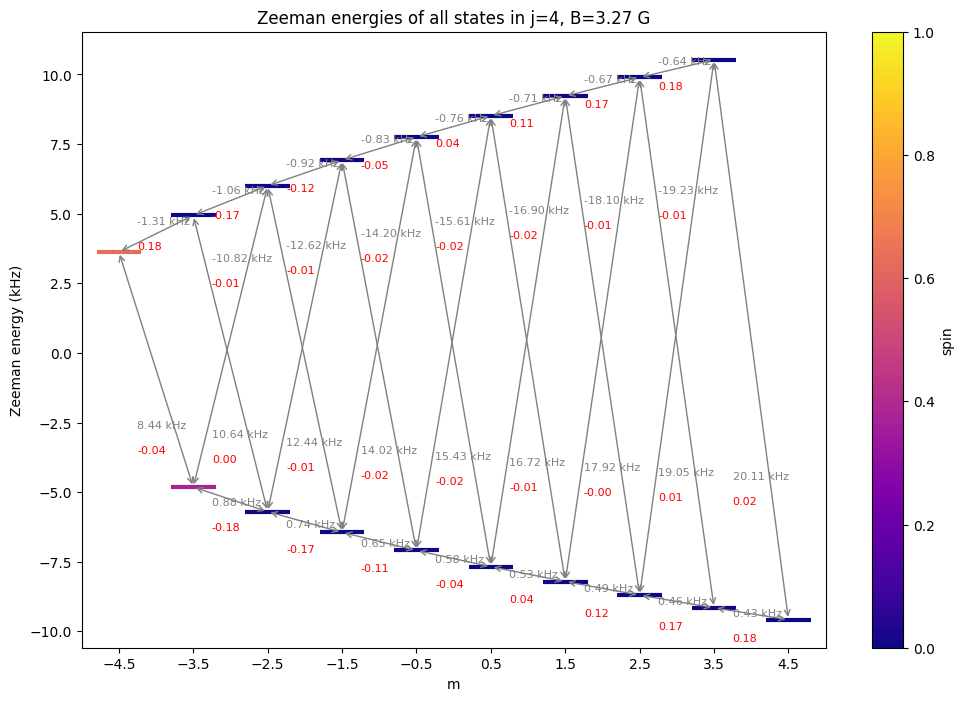

[1.09512332e-002 9.78288636e-049 4.96577694e-049 4.13516201e-049
 8.22560413e-049 5.93788200e-050 1.20487075e-238 4.94065646e-324
 4.94065646e-324 4.43673122e-003 9.51416763e-047 7.97849777e-047
 1.10990730e-046 5.92207390e-046 8.08020206e-074 3.32491615e-233
 4.94065646e-324 4.94065646e-324]
[7.11675234e-001 6.35749220e-047 3.22705253e-047 2.68727033e-047
 5.34547905e-047 3.85878330e-048 7.82995540e-237 3.21142670e-322
 3.21142670e-322 2.88324766e-001 6.18286304e-045 5.18489487e-045
 7.21282733e-045 3.84851028e-044 5.25098828e-072 2.16072514e-231
 3.21142670e-322 3.21142670e-322]


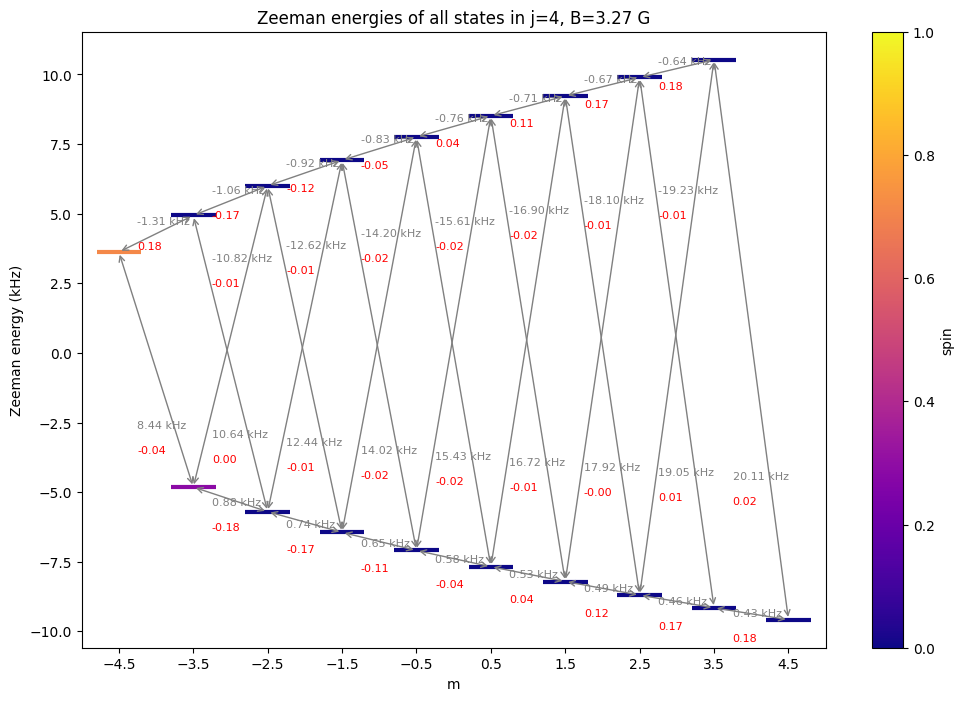

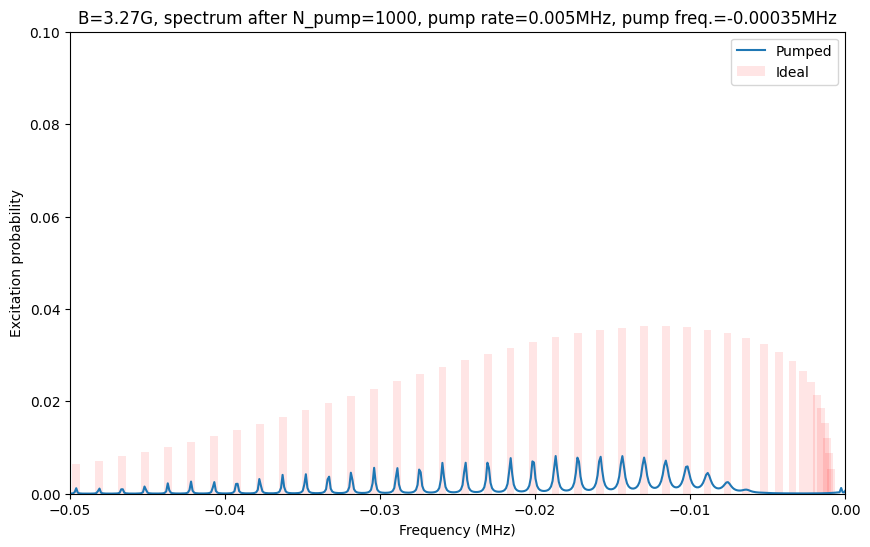

In [26]:
b_field_gauss = 3.27
j_max = 50

mo1 = CaOH.create_molecule_data(b_field_gauss=b_field_gauss, j_max=j_max)

temperature = 300
states1 = qls.States(mo1, temperature)


signature_transitions = np.array([mo1.transition_df.loc[mo1.transition_df["j"]==j].iloc[0]["energy_diff"] * 1e-3 for j in range(1, mo1.j_max+1)])


coherence_time_us = 100
is_minus = True

spectrum_list = {
    'duration_us': 5000,
    'rabi_rate_mhz': 2*np.pi*0.005,
    'max_frequency_mhz': 0.05,
    'scan_points': 1000,
    'dephased': True,
    'coherence_time_us': coherence_time_us,
    'is_minus': is_minus
}


pump_list = {
    'pump_frequency_mhz': 0.00015,
    'num_pumps': 1000,
    'pump_duration_us': 1000.0,
    'pump_rabi_rate_mhz': 2*np.pi*0.005,
    'pump_dephased': True,
    'coherence_time_us': coherence_time_us,
    'is_minus': is_minus
}


apply_pumping(mo1=mo1, **pump_list, noise_params = None, seed = None)
ut.plot_state_dist(mo1, 4)


pump_list['pump_frequency_mhz'] = -0.00035

apply_pumping(mo1=mo1, **pump_list, noise_params = None, seed = None)
ut.plot_state_dist(mo1, 4)


frequencies, exc_probs1_after = get_spectrum(molecule=mo1, state_distribution=mo1.state_df["state_dist"], **spectrum_list, noise_params = None, seed = None)



fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(frequencies, exc_probs1_after, label = f"Pumped")

ax.bar(signature_transitions, states1.j_distribution()[1:], color="red", width=0.0005, alpha=0.1, label = "Ideal")
# ax.axvline(x=pump_frequency_mhz_2, color='black', linestyle='--')
# ax.axvline(x=pump_frequency_mhz_1, color='black', linestyle='--', label=f'Pump freq {pump_frequency_mhz_1*(1e3)} kHz, {pump_frequency_mhz_2*(1e3)} kHz')
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Excitation probability")
ax.set_title(f"B={b_field_gauss}G, spectrum after N_pump={pump_list['num_pumps']}, pump rate={pump_list['pump_rabi_rate_mhz']/(2*np.pi):.3f}MHz, pump freq.={pump_list['pump_frequency_mhz']}MHz")

a_lim = -spectrum_list['max_frequency_mhz']
b_lim = 0

ax.set_xlim([a_lim, b_lim])
ax.set_ylim([0, 0.2])
ax.set_ylim(0,0.1)
ax.legend()
plt.show()

In [45]:
def excitation_matrix(
    mo1, 
    frequency, 
    duration_us, 
    rabi_rate_mhz, 
    dephased=False, 
    coherence_time_us=1000.0, 
    is_minus=True, 
    noise_params=None, 
    seed=None
):
    # Example of what will be received
    print(f"frequency: {frequency}, duration_us: {duration_us}, rabi_rate_mhz: {rabi_rate_mhz}")
    print(f"dephased: {dephased}, coherence_time_us: {coherence_time_us}, is_minus: {is_minus}")
    print(f"noise_params: {noise_params}, seed: {seed}")

# Your parameter dictionaries
excitation_params = {
    'frequency': 1.5e6,
    'duration_us': 5000.0,
    'rabi_rate_mhz': 2*np.pi*0.005,
    'dephased': True,
    'coherence_time_us': 100,
    'is_minus': True
}

noise_params = {'uniform': {'detuning': 0.01, 'rabi_rate': 0.005}}
seed = 42

# Call the function with the unpacked dictionary and additional arguments
excitation_matrix(None, **excitation_params, noise_params=noise_params, seed=seed)


frequency: 1500000.0, duration_us: 5000.0, rabi_rate_mhz: 0.031415926535897934
dephased: True, coherence_time_us: 100, is_minus: True
noise_params: {'uniform': {'detuning': 0.01, 'rabi_rate': 0.005}}, seed: 42


In [8]:
# I suppose that the molecule i give in input is not optically pumped. I do it inside the class, if it's possible
import pandas as pd

class BayesianStateEstimation:

    def __init__(self, model = None, temperature = 300, b_field_gauss = 3.6, j_max = 15):
        self.b_field_gauss = b_field_gauss
        self.j_max = j_max

        if model is None:
            model = CaOH.create_molecule_data(b_field_gauss=self.b_field_gauss, j_max=self.j_max)
        
        self.model = model

        # - If model = None, this if condition will be verified (since no "state_dist" is present)
        # - I pass a model to the class: if qls.States have been previously called, and/or optical pumping already applied, 
        # this if condition will not be verified. If qls.States has not been called to the model before, the if condition will be  
        # verified
        if "state_dist" not in self.model.state_df.columns:
            states1 = qls.States(molecule = self.model, temperature = temperature)

        self.temperature = temperature
        self.init_prior()

        self.history_list = []
        # If I want the dataframe
        # self.df = pd.DataFrame(self.history_list)     


    # prior is the column in the dataframe in the molecule
    def init_prior(self):
        self.prior = self.model.state_df["state_dist"]


    # optical pumping: updates the prior
    def optical_pumping(self, pump_frequency_mhz, num_pumps, pump_duration_us, pump_rabi_rate_mhz, pump_dephased, coherence_time_us, is_minus, noise_params = None, seed = None):
        # BE CAREFUL: if pumping is applied also in the prior updating, be careful that the prior changes and so
        # "state_dist" can be changed accordingly with the updated prior.

        # this function changes the state_dist column of the molecule dataframe
        apply_pumping(self.model, pump_frequency_mhz, num_pumps, pump_duration_us, pump_rabi_rate_mhz, pump_dephased, coherence_time_us, is_minus, noise_params, seed)
        #for this reason, I update the prior
        self.prior = self.model.state_df["state_dist"]
        

    def measurement_setting(self, rabi_rate_mhz, dephased, coherence_time_us, is_minus, noise_params = None, seed = None):
        # the laser field fixes the rabi_rate: it's the same for the measurements that drive transitions and optical pumping.
        # [dephased, coh_time, is_minus] are considered the same for all measurements. can be done differently
        df_trans = self.model.transition_df

        measurements = [[df_trans.loc[df_trans["j"]==j].iloc[0]["energy_diff"] * 1e-3, 
                         np.pi/(rabi_rate_mhz*df_trans.loc[df_trans["j"]==j].iloc[0]["coupling"]), 
                         dephased, 
                         coherence_time_us,
                         is_minus
                         ] for j in range(1, self.j_max+1)]
        
        self.Probs_exc_list = []

        for frequency, duration, deph, coh_time, is_min in measurements:
            state_exc_probs = get_excitation_probabilities(self.model, frequency, duration, rabi_rate_mhz, deph, coh_time, is_min, noise_params, seed)
            self.Probs_exc_list.append(state_exc_probs)

        self.measurements = measurements


    def update_distibution(self, num_updates, apply_pumping = False, save_data = True):
        for _ in range (num_updates):

            # if apply_pumping:
            #   IF PUMPING IS DONE AT EACH PRIOR UPDATE (NAMELY IF IT IS PART OF THE DESIGN)
            #   BE CAREFUL: once the prior is updated, see if the pumping should be applied considering 
            #   as "state_dist" the current prior or not. if yes, then in apply_pumping write 
            #   at the very beginning self.model.state_df["state_dist"] = self.prior

            self.meas_idx = self.get_next_setting()
            data = self.prior

            prob_exc = self.Probs_exc_list[self.meas_idx]

            lh0 = prob_exc
            lh1 = 1 - prob_exc

            self.p0 = np.sum(data*lh0)

            self.outcome = self.outcome_simulation(self.p0) 

            if self.outcome == 0:
                lihelihood = lh0
            else:
                lihelihood = lh1
            
            posterior = self.prior * lihelihood
            posterior = posterior / np.sum(posterior)


            self.likelihood = lihelihood
            self.posterior = posterior

            if save_data:
                self.history_list.append({
                    "meas_idx": self.meas_idx,
                    "measurement": self.measurements[self.meas_idx],
                    "p0": self.p0,
                    "outcome": self.outcome,
                    "prior": self.prior.tolist(),
                    "likelihood": self.likelihood.tolist(),
                    "posterior": self.posterior.tolist()
                })

            # prior updating:
            self.prior = posterior



    def get_next_setting(self):
        # TO CHANGE: for the moment I choose it by myself; it's fixed. Here is where the design should be applied
        idx = 3
        return idx
    

    def outcome_simulation(self, p0):
        # TO CHANGE: for the moment I throw a random number between 0 and 1, and choose accordingly to p0
        # needs to be changes since im extracting the outcome based on the prior knowledge.
        # this_rand = np.random.rand()
        # if this_rand <= p0:
        #     outcome = 0
        # else:
        #     outcome = 1


        this_rand = np.random.rand()
        if this_rand <= 0.5:
            outcome = 0
        else:
            outcome = 1
        return outcome       


        

In [20]:
b_field_gauss = 3.6
j_max = 10

mo1 = CaH.create_molecule_data(b_field_gauss=b_field_gauss, j_max=j_max)

temperature = 300
states1 = qls.States(mo1, temperature)

B = BayesianStateEstimation(model = mo1, temperature=temperature, b_field_gauss=b_field_gauss, j_max = j_max)

In [21]:
rabi_rate_mhz = 2*np.pi*0.004 

# OPTICAL PUMPING 
# pump_frequency_mhz_1 = -0.002
# num_pumps = 200
# pump_duration_us = 1000.0
# dephased = False
# coherence_time_us = 100
# is_minus = True


# spectrum_list = {
#     'duration_us': 5000,
#     'rabi_rate_mhz': 2*np.pi*0.005,
#     'max_frequency_mhz': 0.05,
#     'scan_points': 1000,
#     'dephased': True,
#     'coherence_time_us': coherence_time_us,
#     'is_minus': is_minus
# }


pump_list = {
    'pump_frequency_mhz': -0.002,
    'num_pumps': 200,
    'pump_duration_us': 1000.0,
    'pump_rabi_rate_mhz': rabi_rate_mhz,
    'pump_dephased': False,
    'coherence_time_us': 100,
    'is_minus': True
}


# this changes both the molecule mo1 dataframe (concerning the state_dist) and the B.model molecule (so also the prior)
B.optical_pumping(**pump_list, noise_params = None, seed = None)

In [22]:
pump_list['pump_frequency_mhz'] = -0.006
pump_list['num_pumps'] = 2000

# this changes both the molecule mo1 dataframe (concerning the state_dist) and the B.model molecule (so also the prior)
B.optical_pumping(**pump_list, noise_params = None, seed = None)

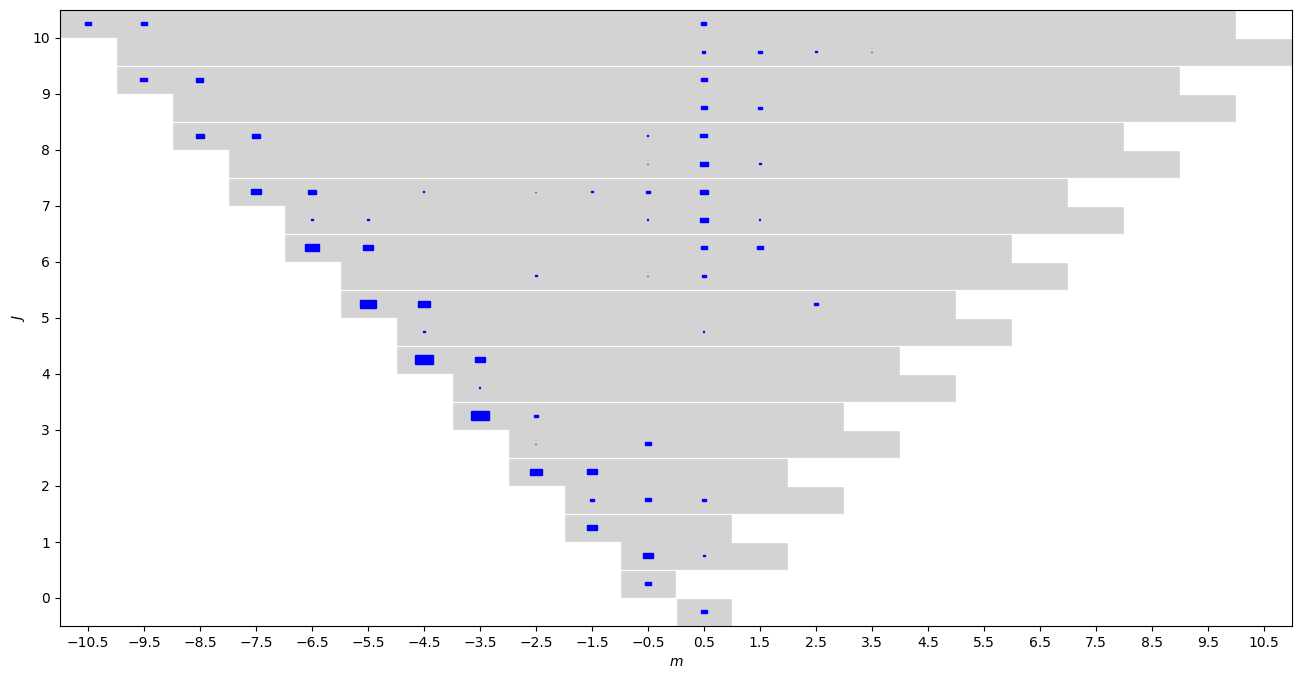

In [23]:
matrix = ut.heatmap_state_pop(mo1.state_df, j_max, normalize = False)
plt.show()

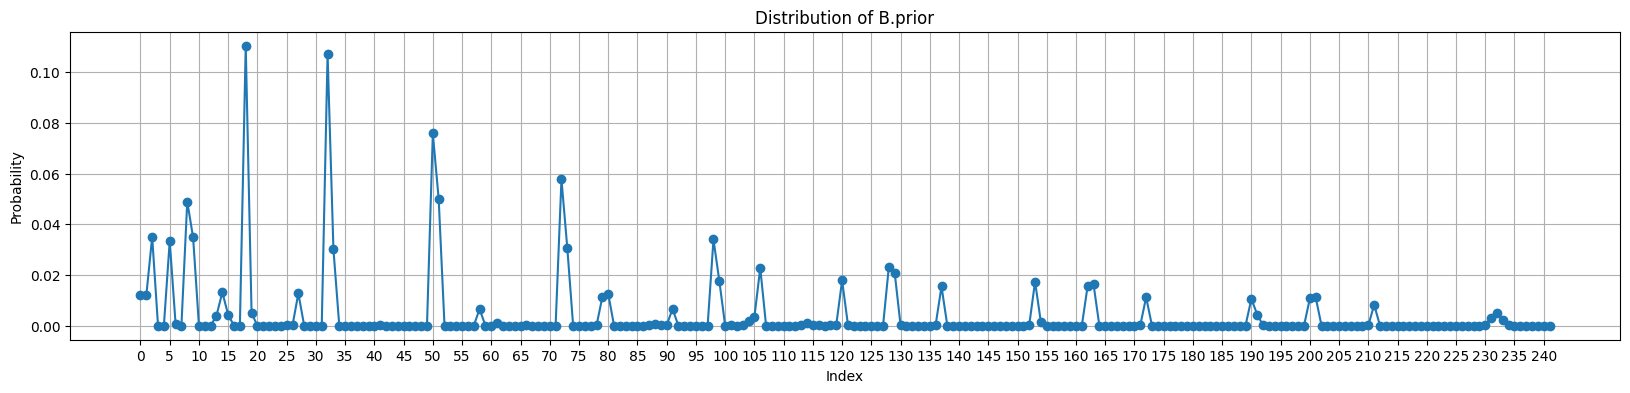

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))
# Assumendo che B.prior sia una Series
plt.plot(B.prior, marker="o", linestyle="-")  # Linea con marker sui punti
plt.xticks(np.arange(0, len(B.prior), step = 5))
plt.xlabel("Index")  # Etichetta asse x
plt.ylabel("Probability")  # Etichetta asse y
plt.title("Distribution of B.prior")  # Titolo del grafico
plt.grid(True)  # Aggiunge griglia
plt.show()  # Mostra il plot

In [25]:
B.measurement_setting(rabi_rate_mhz, dephased = False, coherence_time_us = 100, is_minus = True)
# B.measurements            # list of measurements as [frequency, duration, dephased, coh_time, is_minus]
# B.Probs_exc_list          # list of excitation probabilities, one for each measurement setting

In [26]:
B.update_distibution(num_updates=50, apply_pumping=False, save_data=True)

0.9999001741372945


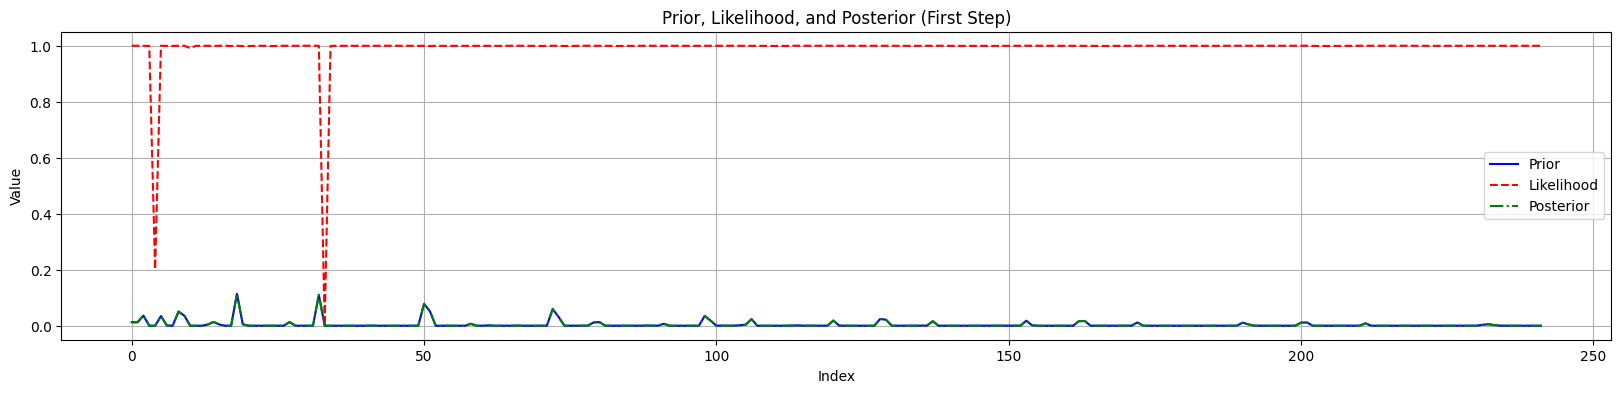

In [27]:
first_entry = B.history_list[2]  

# Estrarre i vettori di prior, likelihood e posterior dal primo step
prior = first_entry["prior"]
likelihood = first_entry["likelihood"]
posterior = first_entry["posterior"]

print(np.sum(np.array(prior)*np.array(likelihood)))

# Indici per l'asse x
indices = list(range(len(prior)))

# Plot
plt.figure(figsize=(20,4))
plt.plot(indices, prior, linestyle="-", color="blue", label="Prior")
plt.plot(indices, likelihood, linestyle="--", color="red", label="Likelihood")
plt.plot(indices, posterior,linestyle="-.", color="green", label="Posterior")

plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Prior, Likelihood, and Posterior (First Step)")
plt.legend()
plt.grid(True)
# plt.xlim(0,40)
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


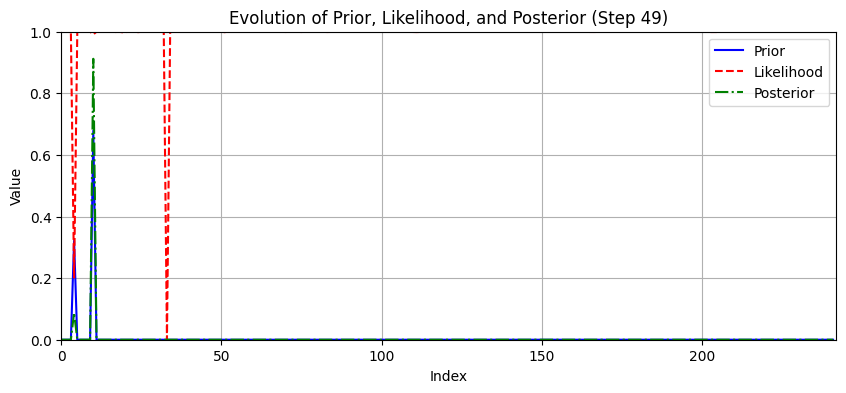

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Get the number of steps in history
num_steps = len(B.history_list)

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 4))

# Initial empty plots
line_prior, = ax.plot([], [], linestyle="-", color="blue", label="Prior")
line_likelihood, = ax.plot([], [], linestyle="--", color="red", label="Likelihood")
line_posterior, = ax.plot([], [], linestyle="-.", color="green", label="Posterior")

ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.set_title("Evolution of Prior, Likelihood, and Posterior")
ax.legend()
ax.grid(True)

# Set x-limits (assuming all distributions have the same length)
xlim = len(B.history_list[0]["prior"])  # Number of elements in each list
ax.set_xlim(0, xlim)
ax.set_ylim(0, 1)  # Adjust as needed

# Update function for animation
def update(step):
    entry = B.history_list[step]  # Get data from the current step
    prior = np.array(entry["prior"])
    likelihood = np.array(entry["likelihood"])
    posterior = np.array(entry["posterior"])

    line_prior.set_data(range(len(prior)), prior)
    line_likelihood.set_data(range(len(likelihood)), likelihood)
    line_posterior.set_data(range(len(posterior)), posterior)
    
    ax.set_title(f"Evolution of Prior, Likelihood, and Posterior (Step {step})")
    
    return line_prior, line_likelihood, line_posterior

# Create animation
ani = animation.FuncAnimation(fig, update, frames=num_steps, interval=200, blit=False)

ani.save("evolution_plot.gif", writer="ffmpeg", fps=2)

# Show animation
plt.show()
